In [1]:
import sys
import os
import json

import torch

from pathlib import Path
from typing import Union
from IPython.display import display, HTML

from PIL import Image

import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

sys.path.append('../')
from utils.general import non_max_suppression
from analysis_app.utils import draw_annotations

%matplotlib inline
alt.data_transformers.disable_max_rows()

display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
root = Path('/mnt/remote/data/users/thomasssajot/yolo_dataset/traffic_lights_entron_classification/focal_len=650__sensor_size_hw=1200x1920/')

files = list(root.glob('RED_SOLID/sedna/2022-05-25--13-27-18--session_2022_04_09_05_21_52_host_zak_complex_intersections2/*.jpeg'))
print(f'Found {len(files)} images.')
assert all([f.exists() for f in files])

# Filter out UNKNOWN class:
len_before = len(files)
files = [f for f in files if f.parent.parent.parent.name != 'UNKNOWN']
print(f'/!\ WARNING /!\: Removing {len_before - len(files)} images with label `UNKNOWN`')

simplified_mapping = {
    'AMBER_SOLID': 'AMBER_SOLID',
    'GREEN_ARROW_LEFT': 'GREEN_SOLID',
    'GREEN_ARROW_RIGHT': 'GREEN_SOLID',
    'GREEN_ARROW_STRAIGHT': 'GREEN_SOLID',
    'GREEN_SOLID': 'GREEN_SOLID',
    'NONE': 'NONE',
    'RED_AND_AMBER': 'RED_AND_AMBER',
    'RED_ARROW_RIGHT': 'RED_SOLID',
    'RED_ARROW_STRAIGHT': 'RED_SOLID',
    'RED_SOLID': 'RED_SOLID',
    'UNKNOWN': 'UNKNOWN'
}
ground_truth_labels = {str(i): simplified_mapping[str(i.relative_to(root)).split('/')[0]] for i in files}

Found 732 images.
/!\ WARNING /!\: Removing 0 images with label `UNKNOWN`


In [3]:
images = [Image.open(f).resize((1600, 1024)) for f in tqdm(files[:5])]
x = np.stack([np.array(i) for i in images])
x = torch.tensor(x / 255).permute(0, 3, 1, 2)
x.shape

  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([5, 3, 1024, 1600])

In [4]:
import torch
model = torch.hub.load(
        repo_or_dir='/mnt/remote/data/users/thomasssajot/yolov5/',
        model='custom', 
        device='mp_inference:cuda:0',
        path='/mnt/remote/data/users/thomasssajot/yolov5/runs/traffic_light_2020_undistorted/yolov5x6_1280_cross_prod_visible_only/weights/best.pt', 
        source='local'
    ) 
model.eval()

WARNING, select device has been modified: cuda:0


Fusing layers... 
2022-10-21 13:19:14.146 INFO    yolov5: Fusing layers... 
Model summary: 416 layers, 140038156 parameters, 0 gradients, 208.0 GFLOPs
2022-10-21 13:19:15.668 INFO    yolov5: Model summary: 416 layers, 140038156 parameters, 0 gradients, 208.0 GFLOPs
Adding AutoShape... 
2022-10-21 13:19:15.677 INFO    yolov5: Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 80, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(80, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(160, 80, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(160, 80, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(160, 160, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(80, 80, kernel_size=(1, 1), stride=(1, 1

In [5]:
res = model(x)

In [6]:
preds = non_max_suppression(res, 0.25, 0.45, model.classes, model.agnostic, model.multi_label, max_det=model.max_det)
preds = [x.cpu().detach().numpy() for x in preds]
preds = [pd.DataFrame(x, columns=['x0', 'y0', 'x1', 'y1', 'confidence', 'class']).assign(sample=i) for i, x in enumerate(preds)]
preds = pd.concat(preds)
preds[['x0', 'y0', 'x1', 'y1', 'class']] = preds[['x0', 'y0', 'x1', 'y1', 'class']].astype(int)
preds['name'] = preds['class'].astype(int).map(model.names.get)

In [23]:
crops = preds.query('sample == 0').copy(True)
crops[['x0', 'y0']] = (crops[['x0', 'y0']] - 100).clip(0) 
crops[['x1', 'y1']] = (crops[['x1', 'y1']] + 100).clip(upper=(1600, 1024)) 

In [27]:
for _, (x0, y0, x1, y1) in crops[['x0', 'y0', 'x1', 'y1']].iterrows():
    print((x0, y0, x1, y1))
#     img = images[0].copy()
#     draw_annotations(img, preds.query('sample == 0').copy(True), size=15)

(666, 355, 874, 575)
(761, 345, 970, 565)
(665, 355, 874, 575)


In [ ]:
img.crop(box=)

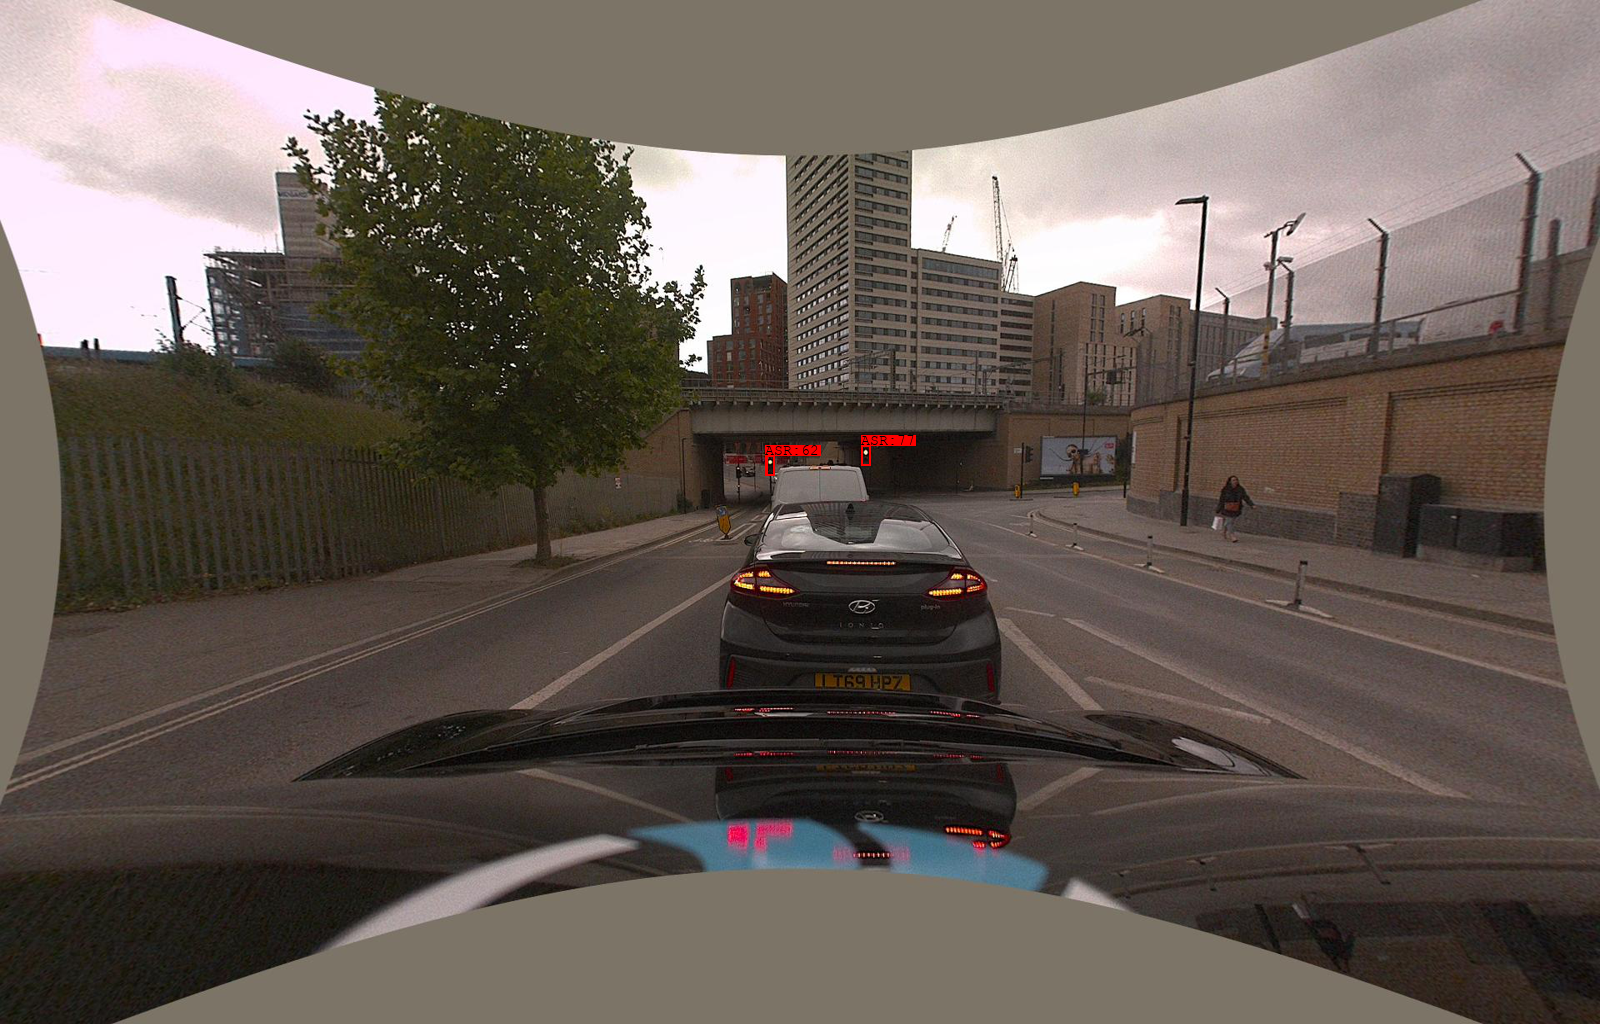

In [10]:
img = images[0].copy()
draw_annotations(img, preds.query('sample == 0').copy(True), size=15)
img

In [65]:
preds.query('sample == 0')

,x0,y0,x1,y1,confidence,class,sample,name
0,766,455,774,475,0.783356,1,0,RED_SOLID_RELEVANT
1,861,445,870,465,0.769610,3,0,AMBER_SOLID_RELEVANT
2,765,455,774,475,0.616765,3,0,AMBER_SOLID_RELEVANT
